In [22]:
import os
from pathlib import Path

if '__setup_done' not in globals():
    os.chdir("..")
    __setup_done = True
    print("디렉토리 변경 완료")
else:
    print("이미 실행됨 - 스킵")

Path.cwd()

이미 실행됨 - 스킵


WindowsPath('d:/02_Projects/Dev/X-ray_AI/Reflecto/runs/exp05_1layer_mask')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from reflecto.simulate.simul_genx import ParamSet, XRRSimulator, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 0.1   # degree
tth_max: float = 15.0
tth_n: int = 300
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

# param = ParamSet(50, 0, 2)
# params = [param]
# refl = params2refl(params, qs)
xrr_sim = XRRSimulator(qs, 1, 1)
thicknesses, roughnesses, slds, refl = next(xrr_sim.make_params_refl())
params = []
for thick, rough, sld in zip(thicknesses, roughnesses, slds, strict=True):
    param = ParamSet(thick, rough, sld)
    print(f"{param:.2f}")
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

: 

In [24]:
import numpy as np
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters

# 1) 측정 데이터 준비
qz = qs
R  = refl
dR = np.maximum(refl*0.3, 1e-8)  # 0 에러 방지 권장

ds = DataSet(name="XRR 1-layer")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

script_text = rf"""
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType

initial_thickness = {param.thickness}
initial_roughness = {param.roughness}
initial_sld = {param.sld * 10e-6}  # Å^-2

SI_SLD = 2.07e-6  # Å^-2
initial_I0 = 1.0
class Vars:
    def __init__(self, d, sigma, sld, i0):
        self._d = float(d)
        self._sigma = float(sigma)
        self._sld = float(sld)
        self._i0 = float(i0)
    def set_thickness(self, v): self._d = float(v)
    def get_thickness(self):    return self._d
    def set_roughness(self, v): self._sigma = float(v)
    def get_roughness(self):    return self._sigma
    def set_sld(self, v): self._sld = float(v)
    def get_sld(self):    return self._sld
    def set_I0(self, v): self._i0 = float(v)
    def get_I0(self):    return self._i0

vars = Vars(initial_thickness, initial_roughness, initial_sld, initial_I0)

Amb  = Layer(d=0.0, dens=0.0, f=0.0)
Sub  = Layer(d = 0.0, f=SI_SLD*1e5, dens=1.0, sigma=3.0)  # ← 1e5
Film = Layer(d=vars.get_thickness(),
             sigma=vars.get_roughness(),
             f=vars.get_sld()*1e6,  # _sync와 동일하게 1e6을 곱해줌
             dens=1.0)
SURFACE_SIO2 = Layer(
    d=15.0,
    f=complex(14, 0.1),
    dens=0.05,
    sigma=2.0
)

sample = Sample(Stacks=[Stack(Layers=[SURFACE_SIO2, Film])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray,
    wavelength=1.54,
    coords=Coords.q,
    I0=vars.get_I0(),
    Ibkg=1e-10,
    res=0.005,
    restype=ResType.fast_conv, # 분해능 컨볼루션
    footype=FootType.gauss
)

def _sync():
    Film.d     = vars.get_thickness()
    Film.sigma = vars.get_roughness()
    Film.f     = vars.get_sld()*1e5
    inst.I0    = vars.get_I0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""
from genx import fom_funcs

# 3) 모델 생성 및 스크립트 설정
model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# 1. 파라미터 등록 (I0 추가)
pars = Parameters()

# (기존 파라미터들 등록 - 일단 fit=False로 둠)
p_thick = pars.append("vars.set_thickness", model)
p_thick.value = param.thickness
p_thick.fit = False  # 일단 끔

p_rough = pars.append("vars.set_roughness", model)
p_rough.value = param.roughness
p_rough.fit = False  # 일단 끔

p_sld = pars.append("vars.set_sld", model)
p_sld.value = param.sld * 1e-5
p_sld.fit = False    # 일단 끔

# [핵심] I0 파라미터 등록 및 켜기
p_i0 = pars.append("vars.set_I0", model)
p_i0.value = 1.0       # 초기값
p_i0.min = 0.1         # 범위 설정
p_i0.max = 10.0
p_i0.fit = True        # 이것만 켬

model.parameters = pars

# ---------------------------------------------------------
# [단계 1] Linear Scale에서 I0만 피팅
# ---------------------------------------------------------
print("--- Step 1: Fitting I0 in Linear Scale ---")

# FOM 함수를 Linear(chi2 또는 abs_diff)로 변경 [cite: 369, 371]
# fom_funcs.chi2는 (sim - meas)^2 / err^2 의 합입니다.
# 로그를 취하지 않으므로 큰 값(전반사 영역)이 피팅을 지배하게 되어 I0 맞추기에 유리합니다.
model.set_fom_func(fom_funcs.diff)

# I0는 단순한 스케일링이므로 복잡한 dream 대신 'de'나 'amoeba'등 으로 빠르게 끝냅니다.
res_i0 = model.bumps_fit(method="de")
model.bumps_update_parameters(res_i0)

print(f"Fitted I0: {p_i0.value}")

# ---------------------------------------------------------
# [단계 2] Log Scale에서 전체 파라미터 피팅
# ---------------------------------------------------------
print("--- Step 2: Full Fitting in Log Scale ---")

# FOM 함수를 다시 Log로 복구 (반사율 피팅의 표준) [cite: 371]
model.set_fom_func(fom_funcs.log)

# 다른 파라미터들 피팅 켜기
p_thick.fit = True
p_rough.fit = True
p_sld.fit   = True
# I0도 미세 조정을 위해 켜두거나, 고정하고 싶으면 False로 변경
p_i0.fit    = False

# 본격적인 피팅 (DE 또는 DREAM)
res_final = model.bumps_fit(method="newton", steps=1000, pop=20, tol=0.01)
model.bumps_update_parameters(res_final)

model.evaluate_sim_func()
print("Final Results:")
for par in model.parameters:
    print(f"  {par.name} = {par.value}")

--- Step 1: Fitting I0 in Linear Scale ---
Fitted I0: 1.0631123358777645
--- Step 2: Full Fitting in Log Scale ---
Final Results:
   = 0.0
  vars.set_thickness = 77.70188491776554
  vars.set_roughness = 1.035749462375794
  vars.set_sld = 2.1308294377104094e-05
  vars.set_I0 = 1.0631123358777645


In [25]:
# GenX 스크립트 모듈에 접근
sm = model.script_module

print("=== 1. Instrument Parameters (기기 설정) ===")
# Instrument 객체 (inst) 확인
print(f"Probe:       {sm.inst.probe}")
print(f"Wavelength:  {sm.inst.wavelength} Å")
print(f"Coords:      {sm.inst.coords}")
print(f"I0 (Scale):  {sm.inst.I0}")
print(f"Background:  {sm.inst.Ibkg}")
print(f"Resolution:  {sm.inst.res} (Type: {sm.inst.restype})")
print(f"Footprint:   {sm.inst.footype}")
print("-" * 30)

print("=== 2. Layer Parameters (박막 구조) ===")
# Film 레이어 확인
print("[Film Layer]")
print(f"  Thickness (d): {sm.Film.d:.4f} Å")
print(f"  Roughness (σ): {sm.Film.sigma:.4f} Å")
print(f"  Density:       {sm.Film.dens}")
# X-ray의 경우 f, 중성자의 경우 b를 확인
if hasattr(sm.Film, 'f'):
    print(f"  X-ray f:       {sm.Film.f}")
if hasattr(sm.Film, 'b'):
    print(f"  Neutron b:     {sm.Film.b}")

print("\n[Substrate Layer]")
print(f"  Roughness (σ): {sm.Sub.sigma:.4f} Å")
if hasattr(sm.Sub, 'f'):
    print(f"  X-ray f:       {sm.Sub.f}")

print("\n[Ambient Layer]")
if hasattr(sm.Amb, 'f'):
    print(f"  X-ray f:       {sm.Amb.f}")
print("-" * 30)

print("=== 3. Fitted User Variables (피팅된 변수들) ===")
# vars 객체 내부 값 확인
print(f"Vars Thickness: {sm.vars.get_thickness():.4f}")
print(f"Vars Roughness: {sm.vars.get_roughness():.4f}")
print(f"Vars SLD:       {sm.vars.get_sld():.4e}")
print(f"Vars I0:        {sm.vars.get_I0():.4f}")

=== 1. Instrument Parameters (기기 설정) ===
Probe:       x-ray
Wavelength:  1.54 Å
Coords:      q
I0 (Scale):  1.0631123358777645
Background:  1e-10
Resolution:  0.005 (Type: fast conv)
Footprint:   gauss beam
------------------------------
=== 2. Layer Parameters (박막 구조) ===
[Film Layer]
  Thickness (d): 77.7019 Å
  Roughness (σ): 1.0357 Å
  Density:       1.0
  X-ray f:       2.1308294377104096
  Neutron b:     0j

[Substrate Layer]
  Roughness (σ): 3.0000 Å
  X-ray f:       (0.20700000000000002+0j)

[Ambient Layer]
  X-ray f:       0j
------------------------------
=== 3. Fitted User Variables (피팅된 변수들) ===
Vars Thickness: 77.7019
Vars Roughness: 1.0357
Vars SLD:       2.1308e-05
Vars I0:        1.0631


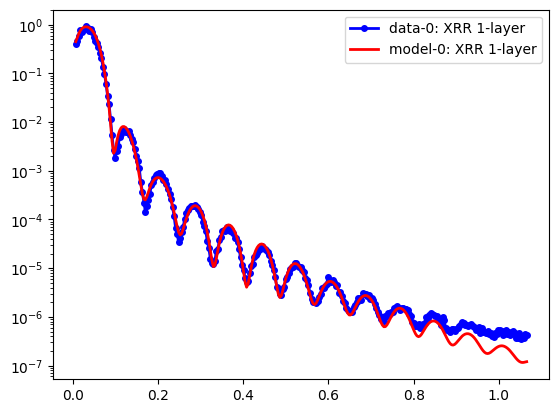

In [26]:
from genx.diffev import DiffEv
from genx.model_control import ModelController

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()

In [27]:
print(fitted.data)

from bumps.fitters import FIT_AVAILABLE_IDS

print(FIT_AVAILABLE_IDS)

DataList([
           DataSet(name=XRR 1-layer    , show=True, use=True, error=False),
           ])

['amoeba', 'de', 'dream', 'newton', 'lm', 'pt']
